# Figure 1: Classification Demonstration

This notebook will reproduce Figure 1 from *Heuristic Methods for Determining the Number of Classes in Unsupervised Classification of Climate Models*, E. Boland et al. 2022 (doi to follow). This requires cluster_utils.py and input datafiles via the googleapi CMIP6 store (see cluster_utils.py for more info).

Please attribute any plots or code from this notebook using the DOI from Zenodo: to come

Updated Nov 2022
E Atkinson & E Boland [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap

import cluster_utils as clu

def get_abt(cov):
  # For finding ellipse parameters from covariance
    w, V = np.linalg.eig(cov)
    t = np.arctan2(V[..., 0, 1], V[..., 0, 0]) * (180 / np.pi)
    return (w[..., 0], w[..., 1], t)

### Step 1: Retrieve the profiles from the CMIP6 googleapi store

In [3]:
data = clu.retrieve_profiles(timeRange = slice('2000-01', '2000-12'))
data

<xarray.DataArray 'thetao' (time: 12, lev: 30, n: 22194)>
dask.array<getitem, shape=(12, 30, 22194), dtype=float32, chunksize=(8, 30, 22194), chunktype=numpy.ndarray>
Coordinates:
    lat      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * lev      (lev) float64 108.0 120.0 133.1 ... 1.653e+03 1.796e+03 1.945e+03
    lon      (n) float32 dask.array<chunksize=(22194,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2000-12-01
  * n        (n) MultiIndex
  - i        (n) int64 0 0 0 0 0 0 0 0 0 ... 359 359 359 359 359 359 359 359 359
  - j        (n) int64 81 82 83 84 85 86 87 88 ... 132 133 134 135 136 137 138
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        mo: This variable is reported using a z* coordinate syste...
    long_name:      Sea Water Potential Temperature
    original_name:  mo: (variable_name: thetao)
    standard_name:  sea_water_potential_temperature
    units:          degC

### Step 2: Create a random sample of profiles, normalise them

In [5]:
data_sampled = clu.random_sample(data, 100).persist() #Takes 100 random Southern Ocean points per month
(data_normalised, data_mean, data_std) = clu.normalise_data(data_sampled, 'N', return_inv=True)

### Step 3: Train a PCA model on the profiles, then transform the profiles to PCA space

In [7]:
n_components = 2
pca = clu.train_pca(data_normalised, n_components)
data_pca = clu.pca_transform(data_normalised, pca)

### Step 4: Train a Gaussian mixture model on the transformed data

In [8]:
n_classes = 3
gmm = clu.train_gmm(data_pca, n_classes)
data_classes = clu.pca_sort(clu.gmm_classify(data_pca, gmm), gmm)

### Create a plot showing each stage

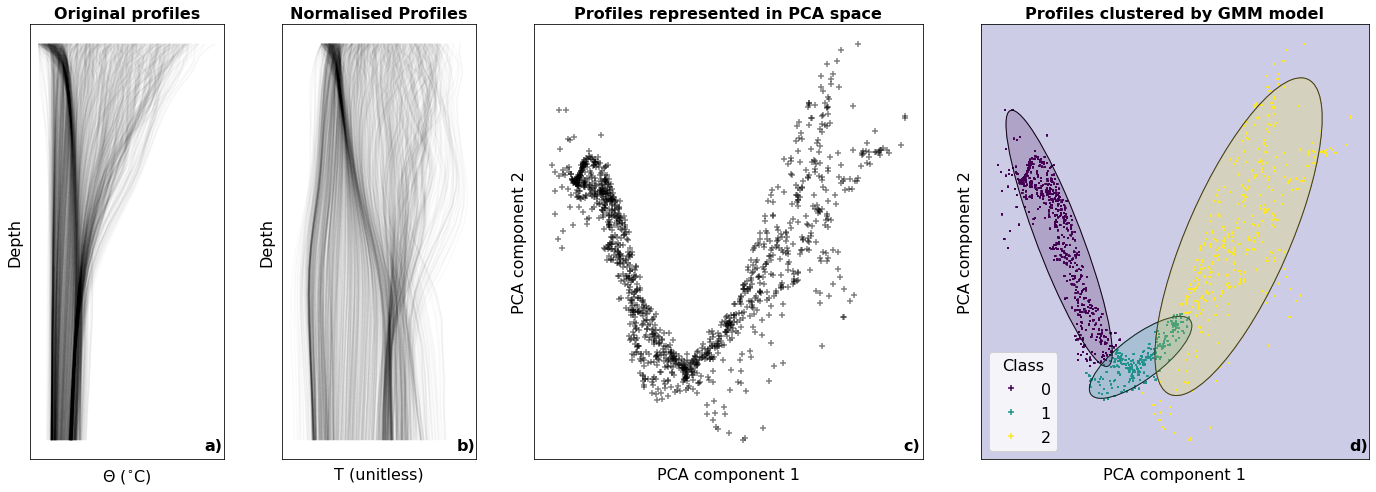

In [41]:
fig, axes = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1,1, 2, 2]})

# Plot the original profiles
axes[0].plot(data_sampled.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
axes[0].text(0.9,0.02,'a)',transform=axes[0].transAxes,fontsize=16,fontweight='bold')
axes[0].set_xlabel('$\Theta$ ($^{\circ}$C)',fontsize=16)
axes[0].set_ylabel('Depth',fontsize=16)
axes[0].set_title('Original profiles',fontsize=16,fontweight='bold')

# Plot the normalised profiles
axes[1].plot(data_normalised.transpose(), -data_sampled['lev'], c=(0, 0, 0, 0.02))
axes[1].text(0.9,0.02,'b)',transform=axes[1].transAxes,fontsize=16,fontweight='bold')
axes[1].set_xlabel('T (unitless)',fontsize=16)
axes[1].set_ylabel('Depth',fontsize=16)
axes[1].set_title('Normalised Profiles',fontsize=16,fontweight='bold')

# Plot the profiles in PCA space
axes[2].scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), color=(0, 0, 0, 0.5), marker='+')
axes[2].text(0.95,0.02,'c)',transform=axes[2].transAxes,fontsize=16,fontweight='bold')
axes[2].set_xlabel('PCA component 1',fontsize=16)
axes[2].set_ylabel('PCA component 2',fontsize=16)
axes[2].set_title('Profiles represented in PCA space',fontsize=16,fontweight='bold')

# Plot the profiles, coloured by GMM class assignment
sc=axes[3].scatter(data_pca.isel(pca_comp=0), data_pca.isel(pca_comp=1), c=data_classes, alpha=1, s=5, cmap='viridis', marker='+')
leg=axes[3].legend(*sc.legend_elements(),title='Class',fontsize=16)
plt.setp(leg.get_title(),fontsize=16)
axes[3].set_xlabel('PCA component 1',fontsize=16)
axes[3].set_ylabel('PCA component 2',fontsize=16)
axes[3].set_title('Profiles clustered by GMM model',fontsize=16,fontweight='bold')

cmap = get_cmap('viridis')
means = gmm.means_
inds = np.argsort(means[:, 0])
means = means[inds, :]

# Get ellipse parameters from GMM covariances
(As, Bs, Ts) = get_abt(gmm.covariances_[inds, :, :])

# Plot an ellipse for each class at equal probabilities
for (i, (a, b, t)) in enumerate(zip(As, Bs, Ts)):
    rgba = list(cmap(i / (n_classes - 1)))
    rgba[-1] = 0.2
    axes[3].add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=False))
    axes[3].add_artist(Ellipse(means[i, :], 4*np.sqrt(a), 4*np.sqrt(b), -t, fill=True, color=rgba))
axes[3].set_facecolor((0.8, 0.8, 0.9))
axes[3].text(0.95,0.02,'d)',transform=axes[3].transAxes,fontsize=16,fontweight='bold')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

fig.set_size_inches(24, 8)

plt.savefig('figures/demo-all', bbox_inches='tight')
plt.show()